# Digit Recognition Using Tensorflow

MNIST Digit Recognition can be regarded as a 'Hello World' into Deep Learning based Computer Vision problems. 
MNIST dataset consists of images of handwritten digits (from 0 to 9). The objective is to recognize any handwritten digit outside the training data. Accuracy is chosen as the performance metric. 

I used Keras API for modelling the 5 layered CNN architecture. This is the overview on the steps I followed:
 After data preparation and checking the missing values, I performed  data augmentation - a way to prevent overfittng and to increase the capability to generalise. Then I modelled a Convolutional Neural Network architecture for solving
Overview: 
 1. Data Preparation
 2. Image Augmentation
 3. Modelling CNN
 4. Training and Validation to get appropriate model
 5. Testing

## 1. Data Preparation



In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In the provided dataset, images are represented as csv data where each entry indicates the intensity value of corresponding pixel. Hence, for a $ 28 \times 28  $ image, there will be $ 28 \times 28 = 784 $ pixel values. So the first step is to prepare the data into appropriate form.  

In [17]:
# Reading the train and test data
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')


print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


There are 42000 training samples and 28000 testing samples. To get an overview, lets see some samples of training data.


In [18]:
train.head()

<bound method NDFrame.head of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pi

The first column of the training sample indicates the label and rest indicates the pixel values. Hence, we need to split the train data into dependent and independent variables and reshape the whole dataset into 2D images.

In [19]:
X_train = train.drop(['label'], axis = 1) #dependent variables 
y_train = train['label'] #independent variable
X_test = test

Lets see if there are any missing values in train and test data

In [20]:
X_train.isnull().sum()

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

In [21]:
X_test.isnull().sum()

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

Above data is in vectorial form (pixel values arranged in a single array). Hence it should be reshaped into the form of 2D images. This is necessary since we are training the data using CNN. 

In [22]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)


In the image data, higher intensity values are represented as $ 255 $, while lower values are represened by $0$ values. However, it is better to normalize the data before training for faster convergence. A simple way to normalize is to divide the whole data by the maximum value (255).

In [23]:
X_train  = X_train/255
X_test  = X_test/255
#The above step can also be done in image augmentation part

Lets see a sample image

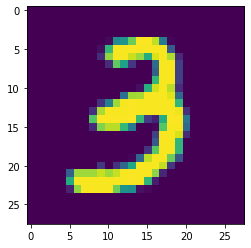

In [24]:

plt.imshow(X_test[7][:,:,0])

To check the distribution of the classes:


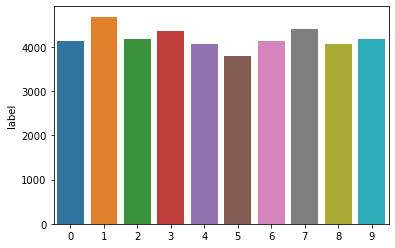

In [25]:
sns.barplot(x = y_train.value_counts().index, y =y_train.value_counts())

Hence, the dataset is almost balanced. Before proceeding to image augmentation part, there is an additional step : One Hot encoding the class labels. In one hot encoding, a binary vector is created corresponding to each classes

In [26]:
 y_train  = tf.keras.utils.to_categorical(y_train)

Now, we can proceed to image augmentation

## 2. Image Augmentation

In simple terms,image augmentation is done to prevent overfitting. For example, if I feed the trained model with a new image for testing, the model should be able to recognize the image even if it is rotated or enlarged or flipped. Hence from the given data, we could generate additonal training data by performing above operations (but vertical flip is not recommended since it could confuse the model from distinguishing 6 and 9). Also, training data is again split into validation set for evaluating the performance. 


In [27]:

# Creating Training and Validation Datasets

from keras.preprocessing.image import ImageDataGenerator
BS = 32    # Batch Size

train_datagen = ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.2,
    validation_split = 0.2)

training_set = train_datagen.flow(
    x = X_train,
    y = y_train,
    batch_size = BS,
    shuffle = True,
    subset = 'training')

validation_set = train_datagen.flow(
    x = X_train,
    y = y_train,
    batch_size = BS,
    shuffle = True,
    subset = 'validation')



In [28]:
# Generating test data
# Do not perform augmentation operation on test data
test_datagen = ImageDataGenerator()
test_set = test_datagen.flow(
    x = X_test,
    y = None,
    batch_size = BS,
    shuffle = False)


## 3. Modelling CNN

I used a 5 layered CNN architecture as the model. At the initial stage, it is prefearrable to use higher filter size ($ 5 \times 5 $ is used in this case) to capture more information. In the second stage the filter size is decreased to $ 3 \times 3 $. The pooling size is chosen as  $ 2 $. 

Relu is chosen as the activation function in hidden stages for faster convergence and adding non linearity to the network. The output of convolution and maxpooling layers is flattened and is fed as input to a 3 layered fully connected (dense) ANN. Relu is also chosen as the activation in these hidden layers also. At the output the softmax is chosen as the activation function which gives the probability distribution of the labels for a given input.


In [29]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 5, activation = 'relu', input_shape = (28,28,1)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 1))

cnn.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 1))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
cnn.add(tf.keras.layers.Dense(units = 10, activation = 'softmax'))

## 4. Training and Validation

Initially, the number of epochs is chosen as 25 (arbitrary value). 

In [30]:
EPOCHS = 25 # No. of Epochs
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
test_model = cnn.fit(training_set, validation_data = validation_set, epochs = EPOCHS)

Epoch 1/25
1050/1050 [==============================] - 65s 61ms/step - loss: 0.1534 - accuracy: 0.9514 - val_loss: 0.1257 - val_accuracy: 0.9619
Epoch 2/25
1050/1050 [==============================] - 64s 61ms/step - loss: 0.0576 - accuracy: 0.9824 - val_loss: 0.0809 - val_accuracy: 0.9768
Epoch 3/25
1050/1050 [==============================] - 64s 61ms/step - loss: 0.0453 - accuracy: 0.9860 - val_loss: 0.0546 - val_accuracy: 0.9851
Epoch 4/25
1050/1050 [==============================] - 63s 60ms/step - loss: 0.0377 - accuracy: 0.9882 - val_loss: 0.0466 - val_accuracy: 0.9848
Epoch 5/25
1050/1050 [==============================] - 64s 61ms/step - loss: 0.0299 - accuracy: 0.9908 - val_loss: 0.0718 - val_accuracy: 0.9818
Epoch 6/25
1050/1050 [==============================] - 64s 61ms/step - loss: 0.0274 - accuracy: 0.9918 - val_loss: 0.0451 - val_accuracy: 0.9864
Epoch 7/25
1050/1050 [==============================] - 64s 61ms/step - loss: 0.0248 - accuracy: 0.9921 - val_loss: 0.0488 -

In [31]:
print(test_model.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


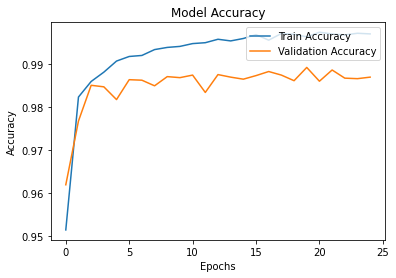

In [32]:
# Plotting training accuracy and validaiton accuracy 
plt.plot(test_model.history['accuracy'])
plt.plot(test_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc = 'upper right')
plt.show()

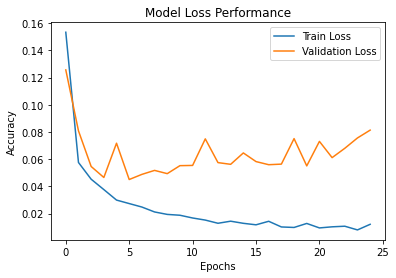

In [33]:
# Plotting training loss and validaiton loss
plt.plot(test_model.history['loss'])
plt.plot(test_model.history['val_loss'])
plt.title('Model Loss Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Loss', 'Validation Loss'], loc = 'upper right')
plt.show()

Initially, for low values of epochs (less than 4), the training accuracy is low which indicates underfitting. 
For number of epochs around 4, the training and validation accuracies are almost the same. 
As the value is increased beyond 8, the both patterns begins to diverge whcih clearly indicates overfitting. Hence for optimal model fitting, the number of epochs is chosen  as 4.

In [34]:
# Final model
cnn.fit(training_set, validation_data = validation_set, epochs = 4)

Epoch 1/4
1050/1050 [==============================] - 64s 61ms/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.0623 - val_accuracy: 0.9876
Epoch 2/4
1050/1050 [==============================] - 64s 61ms/step - loss: 0.0087 - accuracy: 0.9976 - val_loss: 0.0797 - val_accuracy: 0.9860
Epoch 3/4
1050/1050 [==============================] - 68s 65ms/step - loss: 0.0103 - accuracy: 0.9971 - val_loss: 0.0765 - val_accuracy: 0.9874
Epoch 4/4
1050/1050 [==============================] - 64s 61ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.0727 - val_accuracy: 0.9889


## 5. Testing

The final model is used to predict the test data

In [35]:
# Testing a sample image 
# test_image = X_test[7][:,:,0]
# print(type(test_image))
# test_image = np.expand_dims(test_image, axis = 2)
# test_image.shape

In [36]:
predict = cnn.predict_classes(test_set)

In [37]:
# Writing the test results to a separate dataframe
submission = pd.DataFrame()
submission['ImageId'] = pd.Series(range(1,28001))
submission['Label'] = predict
submission.to_csv('submission.csv', index = False)

In [38]:
# plt.imshow(test_set[0][15][:,:,0]

With the final model, I was able to achieve **98.79% accuracy**. I think it is possible to improve the accuracy with a better hyperparameter tuning (no. of hidden layers, no of neurons, optimizer, etc.). I admit earlystopping is the more ideal method to find the optimal number of epochs. But I used  my approach to get a more intuitive feeling of what's really happening. 